## Introduction

Now that we have been introduced to the different statistical models than are used to represent point processes, we turn to the methods that are used to link observed point patterns back to the process that generated the pattern.

More specifically, the challenge that we face is as follows. Given an observed point pattern, we wish to make inferences about the process that generated the observed pattern. 

The general approach that is used is to construct measures that characterise the observed point pattern, and then compare these against the proporties of the theoretical process models we explored previously.

For example, if we assume that the underlying process is CSR, we know what kinds of properties the empirical patterns from such a process should exhibit. The critical thing to keep in mind is that we never actually see the underlying process - we only see outcomes of the process (i.e., the pattern).

This raises a number of challenges that we will need to address later on, but for now we are going to build up an inituition of the general strategy for analyzing point patterns.



## Example Patterns

To begin we are going to create two different point patterns, one from a CSR process and one from a clustered process.
We will use these two patterns to introduce the different statistical methods used to analyze the patterns.
Here we are in the rare circumstance in which we actually know what process generated the pattern. 

### CSR n=60

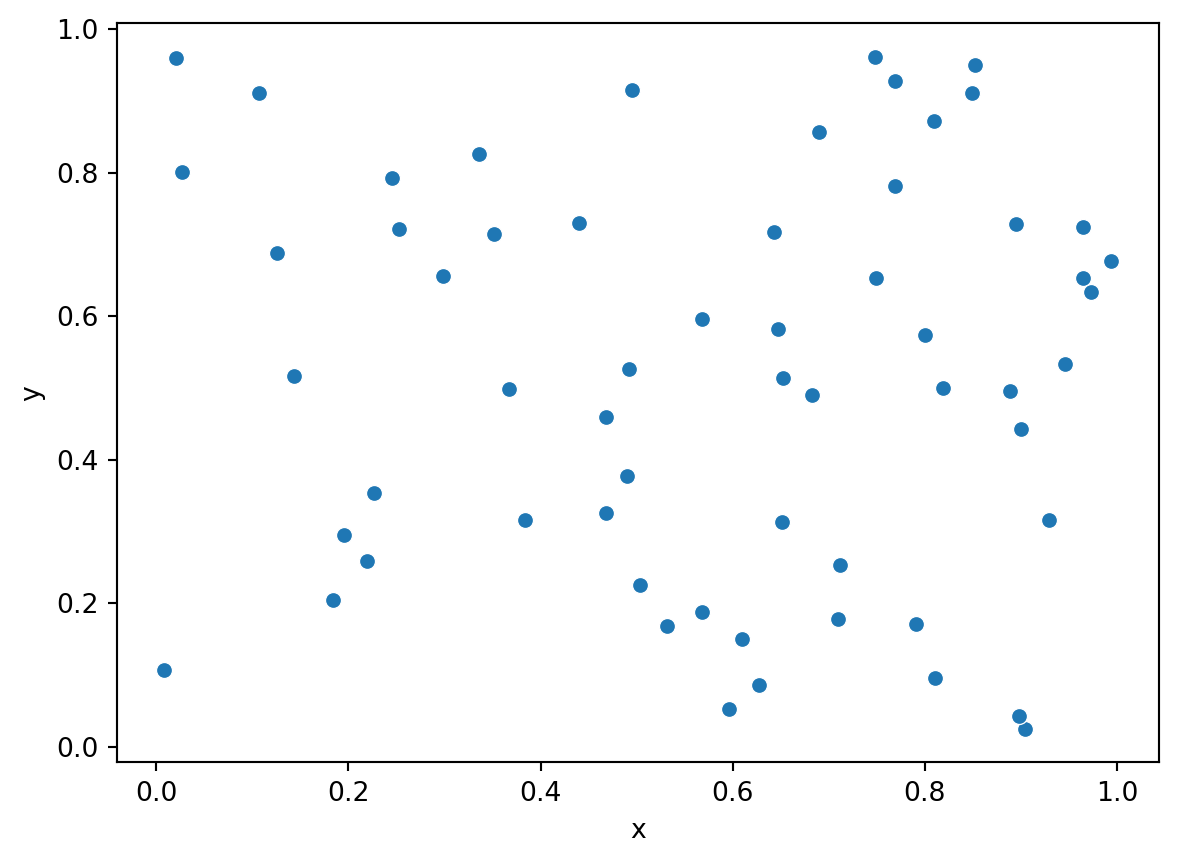

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
np.random.seed(12345)
n = 60
xy = np.random.rand(60,2)
df = pd.DataFrame(data=xy, columns=['x', 'y'])
sns.scatterplot(x='x', y='y', data=df);

In [3]:
import pointpats as pp

In [4]:
csr = pp.PointPattern(xy)

In [5]:
csr.summary()

Point Pattern
60 points
Bounding rectangle [(0.00838829794155349,0.024676210429265266), (0.9940145858999619,0.9613067360728214)]
Area of window: 0.9231676681785911
Intensity estimate for window: 64.99361066054225
          x         y
0  0.929616  0.316376
1  0.183919  0.204560
2  0.567725  0.595545
3  0.964515  0.653177
4  0.748907  0.653570


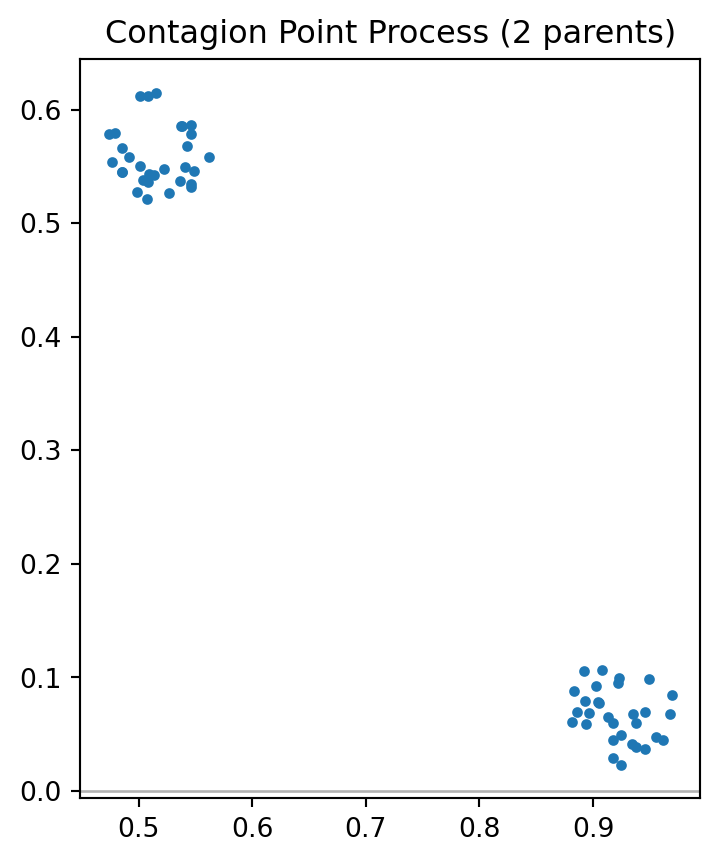

In [6]:
w = pp.Window([(0,0), (0,1), (1,1), (1,0), (0,0)])
draw = pp.PoissonClusterPointProcess(w, n, 2, 0.05, 1, asPP=True, conditioning=False)
draw.realizations[0].plot(window=True, title='Contagion Point Process (2 parents)')

In [7]:
clustered = draw.realizations[0]

In [8]:
clustered.summary()

Point Pattern
60 points
Bounding rectangle [(0.47331760265312733,0.023178703349462502), (0.9696584457277277,0.6150208352748628)]
Area of window: 1.0
Intensity estimate for window: 60.0
          x         y
0  0.513060  0.541971
1  0.473318  0.578385
2  0.508373  0.536200
3  0.881716  0.060328
4  0.894221  0.059273


## Quadrat Statistics

In [9]:
import pointpats.quadrat_statistics as qs

<Axes: title={'center': 'Quadrat Count'}>

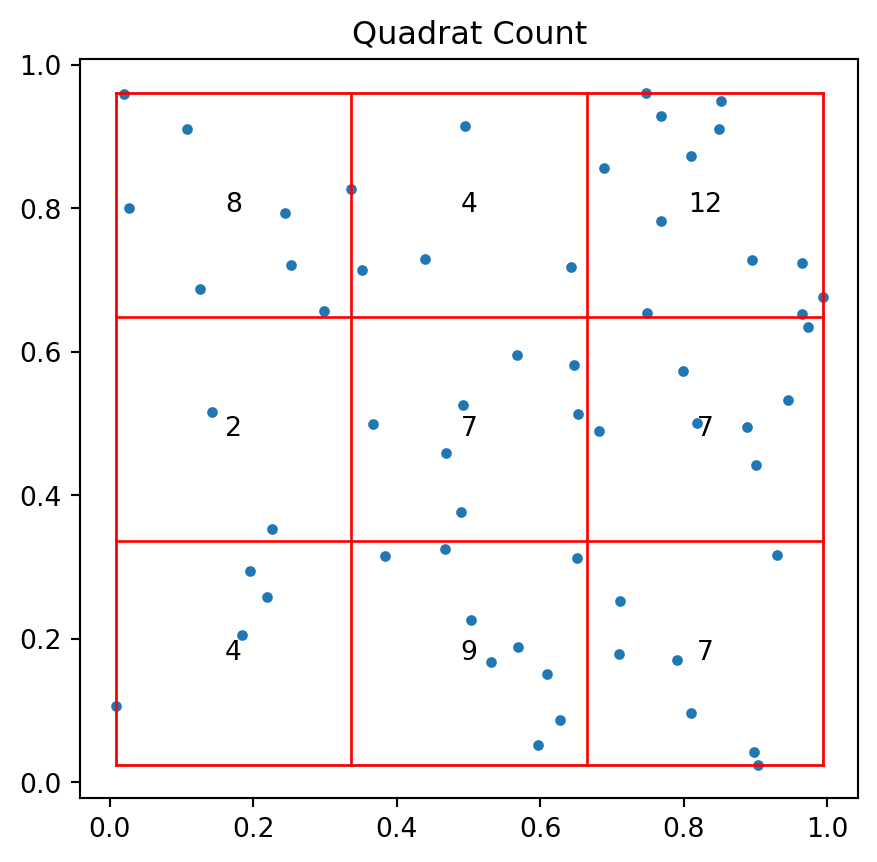

In [10]:
csr_qr = qs.QStatistic(csr, shape='rectangle', nx=3, ny=3)
csr_qr.plot()

In [11]:
csr_qr.chi2

10.8

In [12]:
csr_qr.chi2_pvalue

0.21329101843394052

<Axes: title={'center': 'Quadrat Count'}>

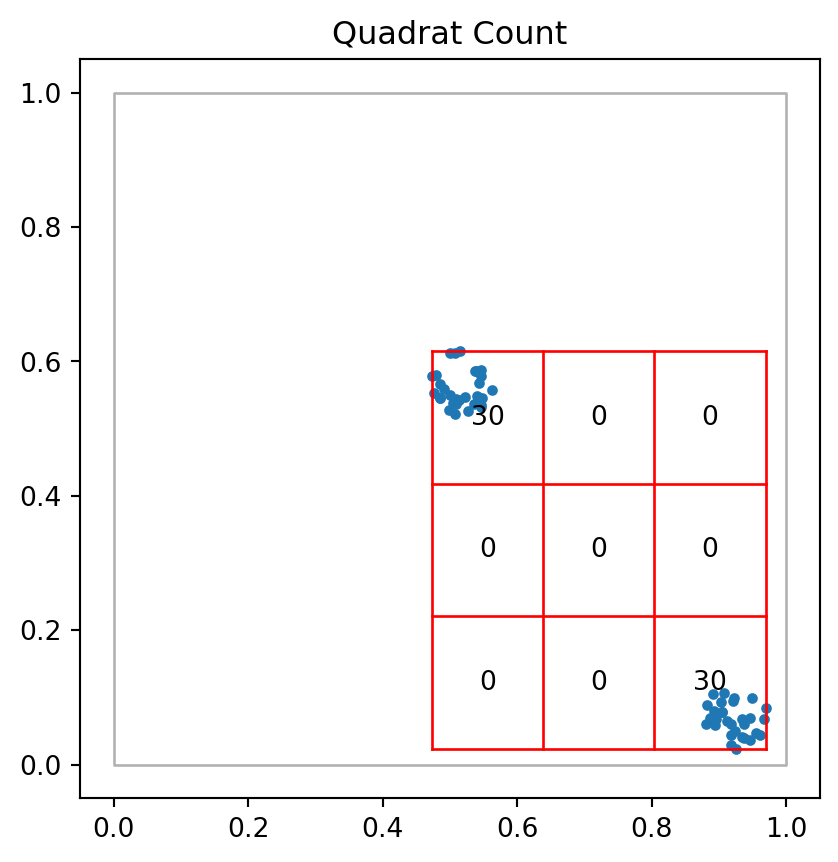

In [13]:
clustered_qr = qs.QStatistic(clustered, shape='rectangle', nx=3, ny=3)
clustered_qr.plot()

In [14]:
clustered_qr.chi2

209.99999999999994

In [15]:
clustered_qr.chi2_pvalue

4.976940117448032e-41

## Nearest Neighbor Distances

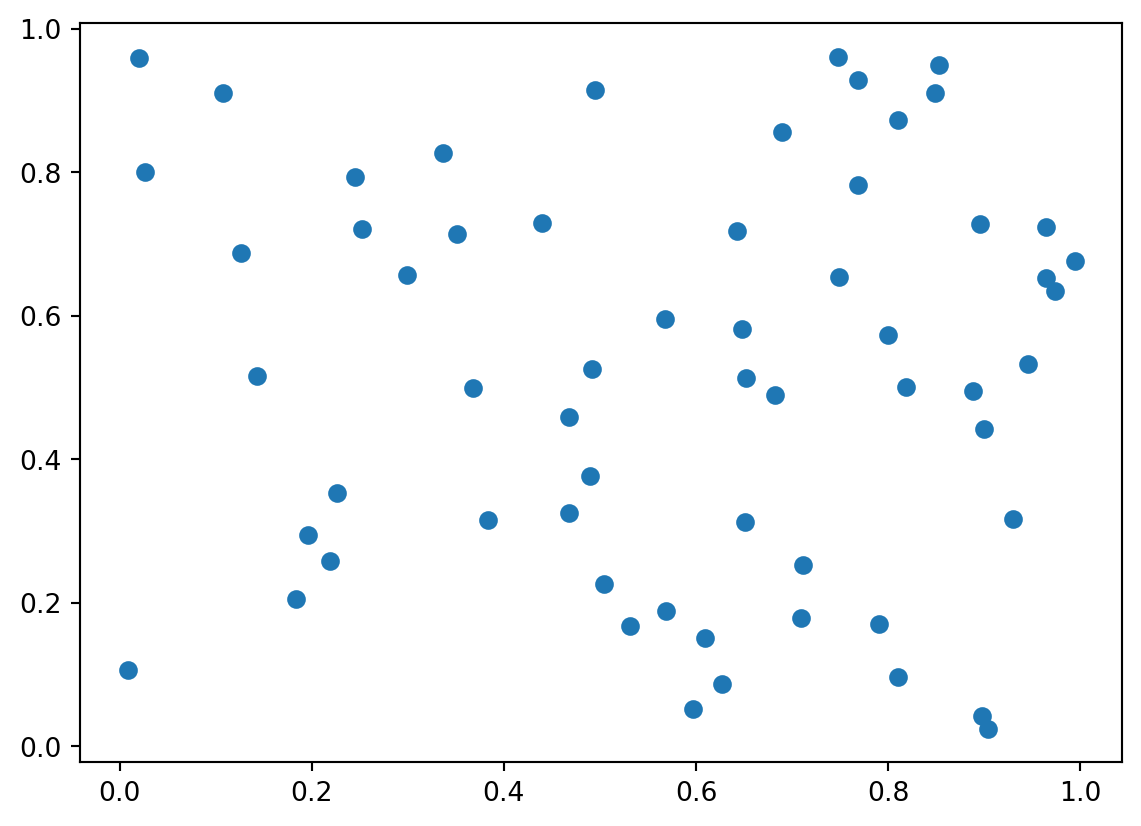

In [16]:
plt.scatter(csr.points.x, csr.points.y);


In [17]:
import networkx as nx

In [18]:
G = nx.DiGraph()
for idx, point in enumerate(csr.points.values):
    G.add_node(idx, pos=point)
    

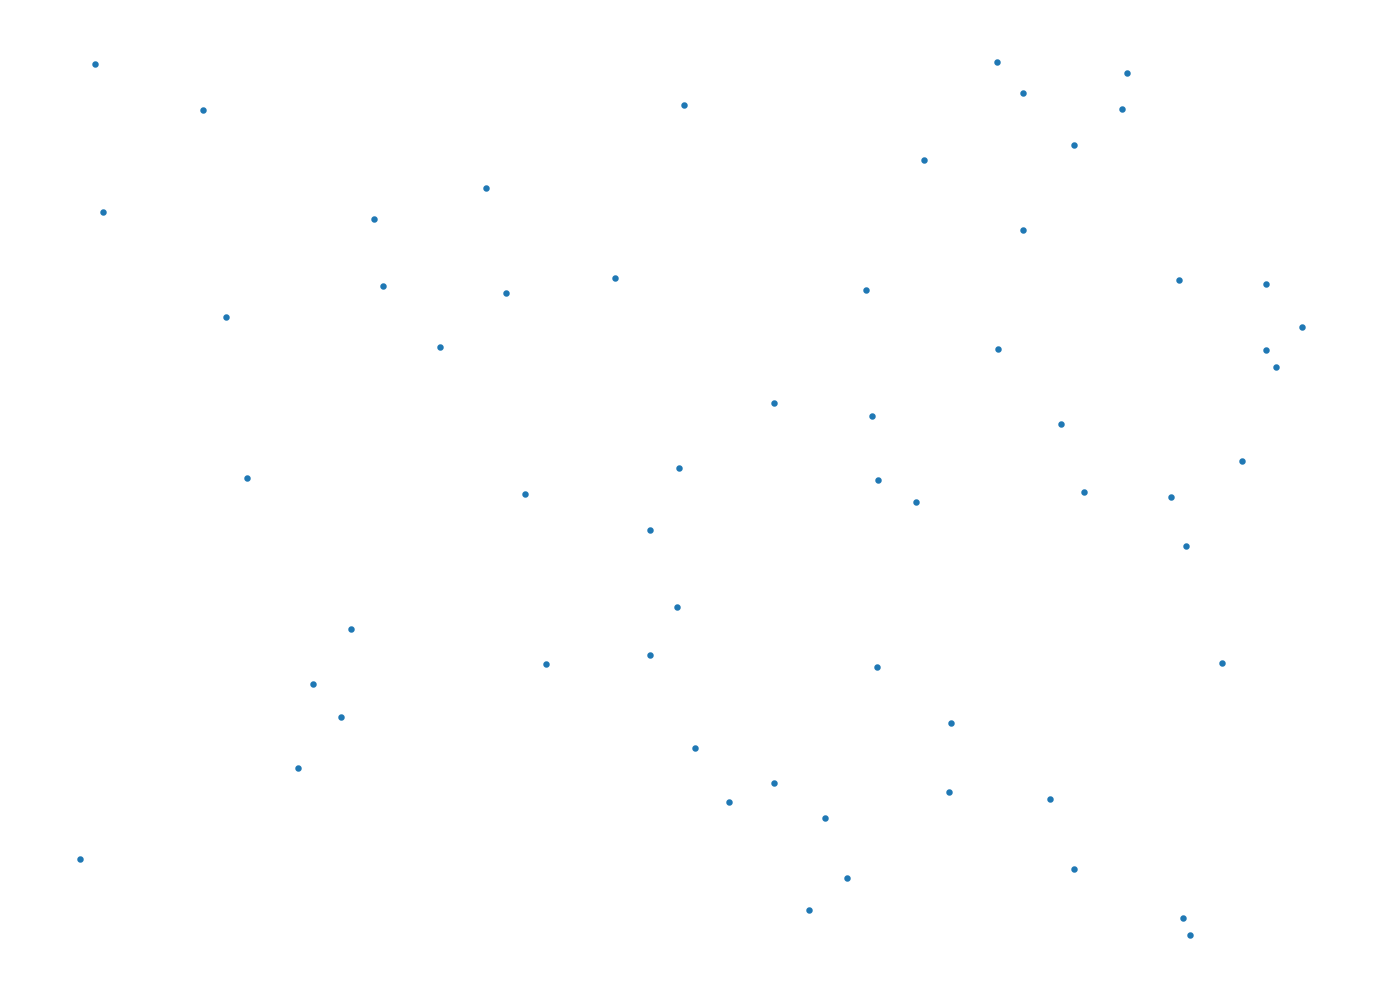

In [19]:
pos = nx.get_node_attributes(G, 'pos')
nx.draw(G, pos, node_size=2)

In [20]:
nidx, nnd = csr.knn(1) # here we have the indices of the nearest neighbors (nidx) and the distances (nnd)

In [21]:
for idx, neighbor in enumerate(nidx):
    edge = (idx, neighbor[0])
    G.add_edges_from([edge])
    

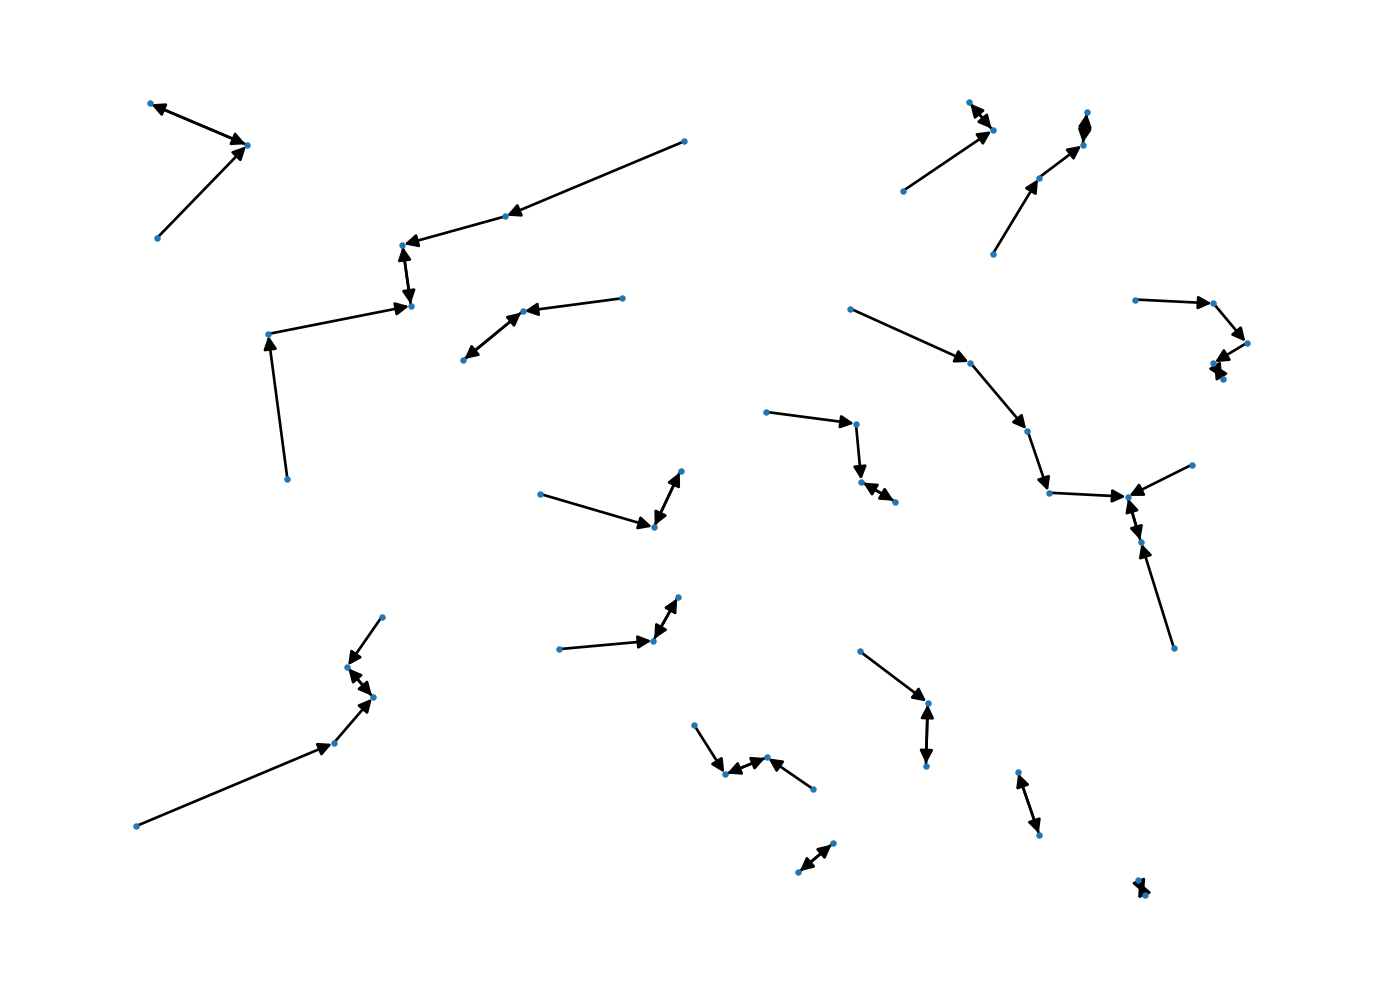

In [22]:
pos = nx.get_node_attributes(G, 'pos')
nx.draw(G, pos, node_size=2)

Here we draw an arrow towards  the nearest neighbor for a given observation.

In some cases, an observation is also the nearest neighbor to its nearest neighbor, or so-called "mutual nearest neighbors". These pairs would appear at the the end of a segment with arrows on both ends.

If we look in the extreme northwest three points, we see one pair of mutual nearest neighbors, while the third point is not a mutual nearest neighbor.

It is also possible for a point to be a nearest neighbor to more than a single point, as is also seen in this case.

The **nearest neighbor distances** are the lengths of these segments.

### Mean Nearest Neighbor Distance

Our first distance based statistic was suggested by Clark and Evans (1954) as the average nearest neighbor distances:

$$\bar{d}_{min} = \frac{1}{n} \sum_{i} d_{i, min} $$

where $d_{i, min}$ is the nearest neighbor distance for observation $i$, and $n$ is the number of observations.

Under a CSR process, the expected value of this statistic is:

$$E[\bar{d}_{min}] = \frac{1}{2 \sqrt{\lambda}}$$

The logic of the statistic is to compare the *observed* mean nearest neighbor distance to this expectation forming their ratio:

$$R = \frac{\bar{d}_{min}}{\frac{1}{2 \sqrt{\lambda}}} = 2 \bar{d}_{min} \sqrt{\lambda}$$

Values of $R<1$ are indicative of a tendancy towards clustering since the observed nearest neighbor distances are smaller than expected under CSR.

Values of $R>1$ are indicative of a uniform or dispersed pattern.

In [23]:
nnd.mean() # the mean nearest neighbor distance

0.07360281110243255

In [24]:
csr.lambda_window # the intensity using the window for the point pattern

64.99361066054225

In [25]:
dmin = nnd.mean()
lam = csr.lambda_window
R = 2 * dmin * lam**(1/2)
R

1.1867513365512292

Let's compare this to the same statistic based on the mean nearest neighbor distance for the clustered pattern:

In [26]:
nidx, nnd = clustered.knn(1) # here we have the indices of the nearest neighbors (nidx) and the distances (nnd)

In [27]:
dmin = nnd.mean()
lam = clustered.lambda_window
R = 2 * dmin * lam**(1/2)
R

0.13087134840769868

So we see that the $R$ value for the clustered pattern is much below 1, while the R value for the CSR pattern is slightly over 1.

What we would like to know is if these values are significantly different from what we would expect if the underlying process that generated the patterns was CSR?

One approach is to use theoretical results on the distribution for the $R$ statistic from Petrere (1985). The expected value of $R$ is $E[R]=1$. The variance of the $R$ statistic is:
$$ \sigma^2_R = \frac{0.2732}{n}$$

In [28]:
import scipy.stats
def R_test(pattern):
    nidx, nnd = pattern.knn(1) # here we have the indices of the nearest neighbors (nidx) and the distances (nnd)
    lam = pattern.lambda_window
    R = 2 * nnd.mean() * lam**(1/2)
    n = nnd.shape[0]
    var = 0.2732 / n
    se = var**(1/2)
    stat = (R - 1 )/ se
    p_value = scipy.stats.norm.sf(abs(stat)) * 2
    return R, stat, p_value


In [29]:
R_test(csr)

(1.1867513365512292, 2.7675724348891184, 0.005647549379017387)

In [30]:
R_test(clustered)

(0.13087134840769868, -12.880103258909552, 5.82575657521834e-38)

### Inference via simulation

In [31]:
import pointpats
import numpy
samples = pointpats.PoissonPointProcess(csr.window, n, 99, asPP=True)

r_tests = np.array([R_test(samples.realizations[k]) for k in samples.realizations])

r_tests

array([[ 9.81105197e-01, -2.80012645e-01,  7.79467803e-01],
       [ 9.28415089e-01, -1.06085681e+00,  2.88754981e-01],
       [ 1.05435206e+00,  8.05473519e-01,  4.20546481e-01],
       [ 1.11821360e+00,  1.75187335e+00,  7.97955886e-02],
       [ 1.12387424e+00,  1.83576157e+00,  6.63929272e-02],
       [ 1.16724422e+00,  2.47848561e+00,  1.31941433e-02],
       [ 1.10700813e+00,  1.58581325e+00,  1.12781678e-01],
       [ 1.09108797e+00,  1.34988348e+00,  1.77053361e-01],
       [ 9.69002352e-01, -4.59371472e-01,  6.45967431e-01],
       [ 1.03760497e+00,  5.57289124e-01,  5.77329905e-01],
       [ 1.02704882e+00,  4.00851546e-01,  6.88529426e-01],
       [ 1.10508460e+00,  1.55730742e+00,  1.19397514e-01],
       [ 1.15793416e+00,  2.34051463e+00,  1.92571837e-02],
       [ 1.04250723e+00,  6.29938355e-01,  5.28734918e-01],
       [ 1.10758728e+00,  1.59439606e+00,  1.10847354e-01],
       [ 1.07177650e+00,  1.06369612e+00,  2.87466383e-01],
       [ 1.02551521e+00,  3.78124168e-01

In [32]:
R_csr = R_test(csr)

In [33]:
R_csr[0]

1.1867513365512292

In [34]:
(r_tests[:,0] >= R_csr[0]).sum()

4

In [35]:
R_clustered = R_test(clustered)

In [36]:
import pandas

import seaborn as sns

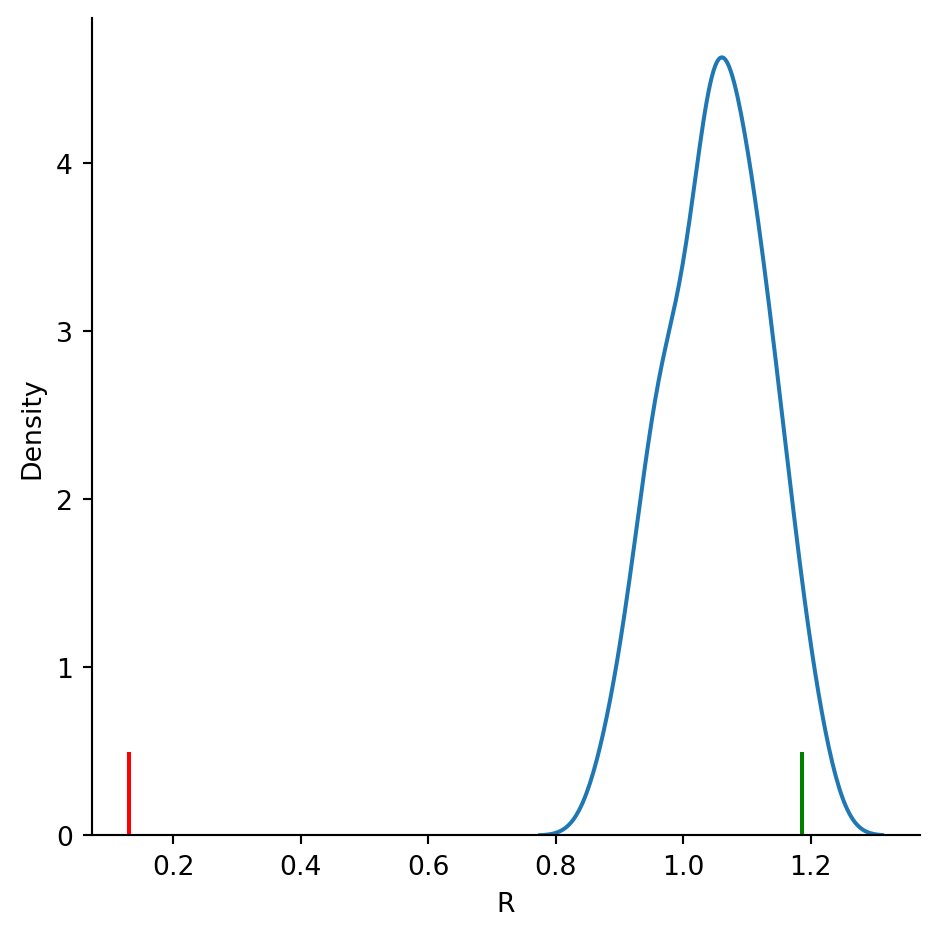

In [37]:
df = pandas.DataFrame(data=r_tests, columns=['R', 'z', 'p'])

sns.displot(df, kind='kde', x="R")
plt.axvline(R_csr[0], 0, 0.1, color='g');
plt.axvline(R_clustered[0], 0, 0.1, color='r');

In [38]:
df.describe()

,R,z,p
count,99.000000,99.000000,99.000000
mean,1.052286,0.774857,0.357230
std,0.078631,1.165280,0.282182
min,0.869472,-1.934369,0.001262
25%,0.991487,-0.126153,0.099093
50%,1.054352,0.805474,0.295117
75%,1.108215,1.603696,0.581644
max,1.217576,3.224375,0.941421


In [39]:

samples = pointpats.PoissonPointProcess(csr.window, n, 999, asPP=True)

r_tests = np.array([R_test(samples.realizations[k]) for k in samples.realizations])

r_tests

array([[ 1.04108274,  0.60882811,  0.54263838],
       [ 1.08726785,  1.2932711 ,  0.19591731],
       [ 0.96240692, -0.5571128 ,  0.57745036],
       ...,
       [ 1.18467435,  2.73679237,  0.00620414],
       [ 1.05998867,  0.88900566,  0.37400004],
       [ 0.92024492, -1.18193507,  0.23723146]])

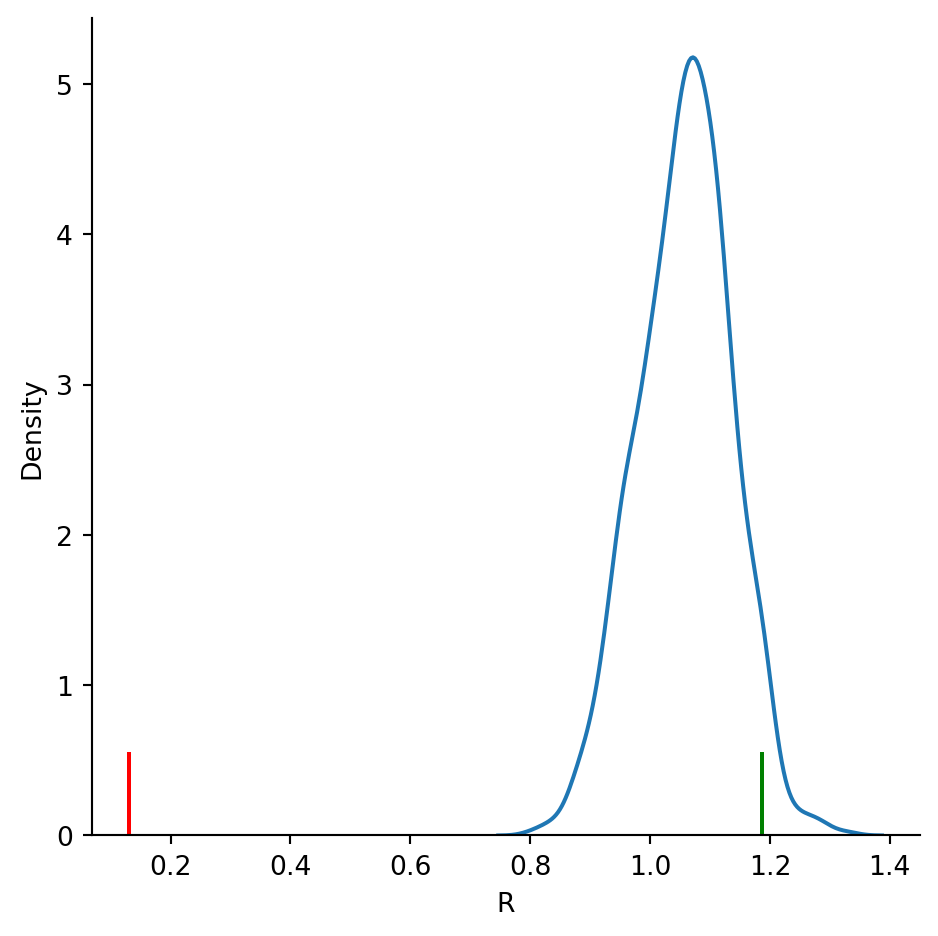

In [40]:
df = pandas.DataFrame(data=r_tests, columns=['R', 'z', 'p'])

sns.displot(df, kind='kde', x="R")
plt.axvline(R_csr[0], 0, 0.1, color='g');
plt.axvline(R_clustered[0], 0, 0.1, color='r');

In [41]:
df.describe()

,R,z,p
count,999.000000,999.000000,999.000000
mean,1.057947,0.858756,0.357294
std,0.077832,1.153438,0.296165
min,0.805327,-2.884969,0.000001
25%,1.004814,0.071334,0.092286
50%,1.061867,0.916842,0.283196
75%,1.111235,1.648461,0.577714
max,1.328334,4.865765,0.998563
